In [1]:
from pytorch_tools import CreateDataset, train_model_cls, train_model_reg, plot_metrics

## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
parameters

[Parameter containing:
 tensor([[-0.1576,  0.0677, -0.2165,  0.1078,  0.1885,  0.1362, -0.0187,  0.0184,
           0.2248, -0.1118,  0.1205, -0.0242,  0.1951, -0.1929, -0.0302, -0.1234,
          -0.1440,  0.0525]], requires_grad=True),
 Parameter containing:
 tensor([-0.1752], requires_grad=True)]

In [9]:
metrics, model = train_model_cls(
    num_classes=2,
    num_epoch=30,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

Epoch [10/30] Train Loss: 0.7869 Acc: 0.3973 Rec: 0.2861 Prec: 0.3721
Epoch [20/30] Train Loss: 0.7692 Acc: 0.4062 Rec: 0.2772 Prec: 0.3780
Epoch [30/30] Train Loss: 0.7527 Acc: 0.4229 Rec: 0.2690 Prec: 0.3933


In [10]:
with torch.no_grad():
    y_pred = model(X_test).squeeze().numpy().round()

accuracy_score(y_test, y_pred)

0.5967235970721506

In [11]:
parameters

[Parameter containing:
 tensor([[-0.0706,  0.0500, -0.2101,  0.0672,  0.1843,  0.1265, -0.0527, -0.0150,
           0.2098, -0.1062,  0.0864,  0.0030,  0.1819, -0.1745, -0.0128, -0.1139,
          -0.1358,  0.0289]], requires_grad=True),
 Parameter containing:
 tensor([-0.1620], requires_grad=True)]

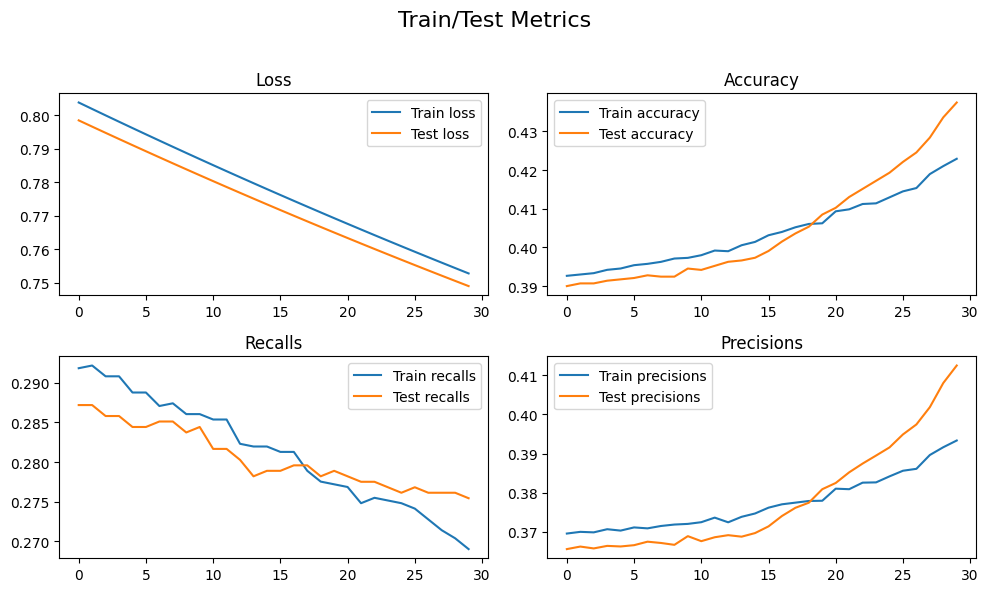

In [12]:
plot_metrics(metrics)

## multyclass classification

In [13]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [15]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [16]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [17]:
train_dataset.scaler

StandardScaler()

In [18]:
num_classes = len(np.unique(y_train))

In [19]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [20]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [21]:
metrics, model = train_model_cls(
    num_classes=num_classes,
    num_epoch=100,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer
)

Epoch [10/100] Train Loss: 0.9897 Acc: 0.6943 Rec: 0.6943 Prec: 0.5836
Epoch [20/100] Train Loss: 0.9043 Acc: 0.6943 Rec: 0.6943 Prec: 0.5844
Epoch [30/100] Train Loss: 0.8340 Acc: 0.6943 Rec: 0.6943 Prec: 0.5810
Epoch [40/100] Train Loss: 0.7875 Acc: 0.6943 Rec: 0.6943 Prec: 0.5767
Epoch [50/100] Train Loss: 0.7571 Acc: 0.6981 Rec: 0.6981 Prec: 0.6077
Epoch [60/100] Train Loss: 0.7344 Acc: 0.7636 Rec: 0.7636 Prec: 0.7465
Epoch [70/100] Train Loss: 0.7146 Acc: 0.8145 Rec: 0.8145 Prec: 0.8910
Epoch [80/100] Train Loss: 0.6956 Acc: 0.8716 Rec: 0.8716 Prec: 0.9451
Epoch [90/100] Train Loss: 0.6773 Acc: 0.8933 Rec: 0.8933 Prec: 0.9550
Epoch [100/100] Train Loss: 0.6608 Acc: 0.9192 Rec: 0.9192 Prec: 0.9682


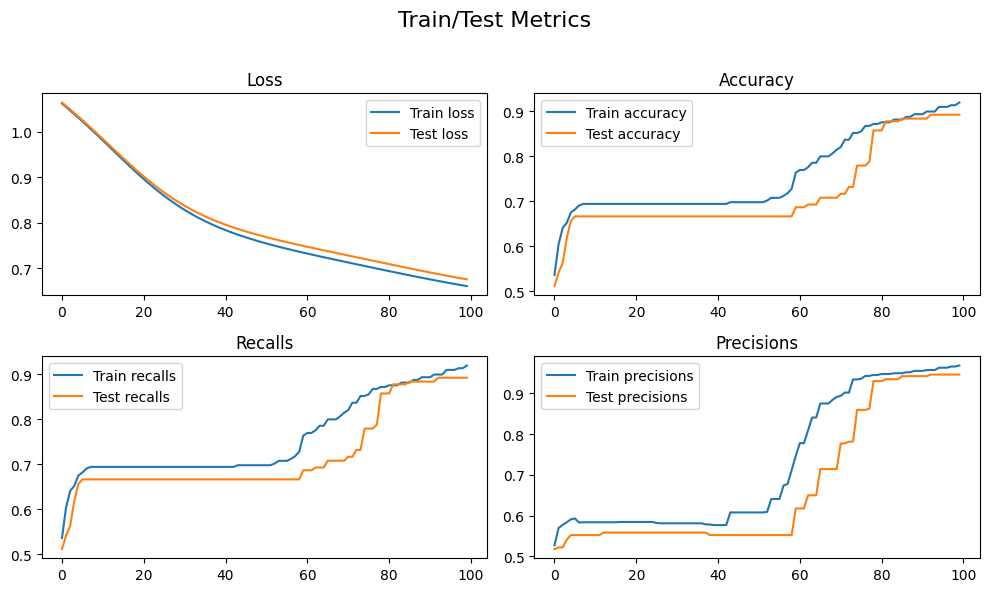

In [22]:
plot_metrics(metrics)

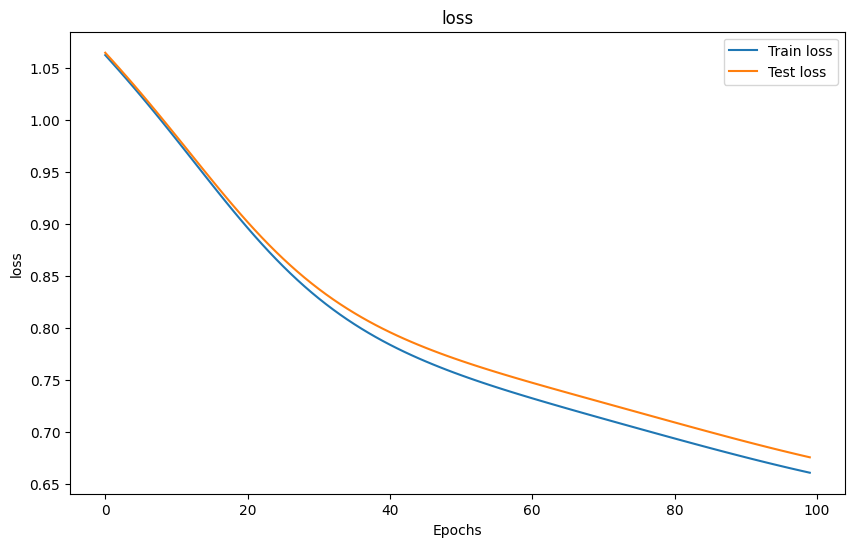

In [23]:
plot_metrics(metrics, 'loss')

## regression

In [24]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [25]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [26]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6818, 12), (1705, 12), (6818,), (1705,))

In [28]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [29]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [30]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [31]:
metrics, model = train_model_reg(num_epoch=100,
                    train_dataloader = train_dataloader,
                    test_dataloader = test_dataloader,
                    model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    )

Epoch [10/100] Train Loss: 1274964.7739 MSE: 1274964.7739 MAE: 821.3662 RMSE: 1129.1434
Epoch [20/100] Train Loss: 1239431.7257 MSE: 1239431.7257 MAE: 795.8071 RMSE: 1113.2977
Epoch [30/100] Train Loss: 1222602.8042 MSE: 1222602.8042 MAE: 787.4169 RMSE: 1105.7137
Epoch [40/100] Train Loss: 1209328.3804 MSE: 1209328.3804 MAE: 781.1700 RMSE: 1099.6947
Epoch [50/100] Train Loss: 1198505.4841 MSE: 1198505.4841 MAE: 775.9583 RMSE: 1094.7628
Epoch [60/100] Train Loss: 1189880.4979 MSE: 1189880.4979 MAE: 771.7160 RMSE: 1090.8164
Epoch [70/100] Train Loss: 1183335.5645 MSE: 1183335.5645 MAE: 768.4907 RMSE: 1087.8123
Epoch [80/100] Train Loss: 1178483.6734 MSE: 1178483.6734 MAE: 766.0611 RMSE: 1085.5799
Epoch [90/100] Train Loss: 1174765.8176 MSE: 1174765.8176 MAE: 764.1818 RMSE: 1083.8661
Epoch [100/100] Train Loss: 1171794.8778 MSE: 1171794.8778 MAE: 762.6969 RMSE: 1082.4947


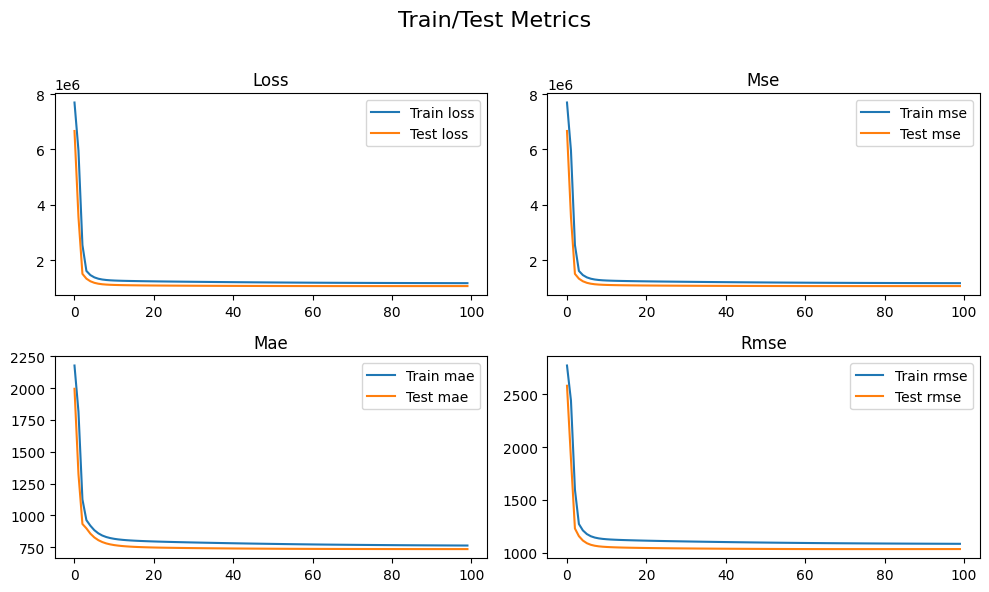

In [32]:
plot_metrics(metrics)